In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from tqdm import tqdm 
import matplotlib.pyplot as plt 

In [2]:
df_train = pd.read_csv("train.csv")
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

большой дисбаласн классов, подготовим 3 выборки, 
- X_train_samp - продублируем класс1 для сбалансированности, и на этой выборке будем производить обучение сети
- X_train - выборку оставим без изменения что бы при обучении считать метрику на train
- X_val - валидационная выборка

In [3]:
X_train, X_val = train_test_split(df_train, test_size=0.15, random_state=42)

In [4]:
X_train['label'].value_counts()

0    25252
1     1915
Name: label, dtype: int64

In [5]:
class0 = X_train.loc[X_train['label']==0]
class1 = X_train.loc[X_train['label']==1]
X_train_samp = class0.append(pd.DataFrame(np.repeat(class1.values, 13, axis=0), columns=class1.columns), ignore_index=True)

In [6]:
y_train_samp = X_train_samp['label'].astype(np.int32)
X_train_samp = X_train_samp.drop(columns=['label'])
y_train_samp.value_counts()

0    25252
1    24895
Name: label, dtype: int64

In [7]:
y_train = X_train['label'].astype(np.int32)
X_train = X_train.drop(columns=['label'])
y_train.value_counts()

0    25252
1     1915
Name: label, dtype: int64

In [8]:
y_val = X_val['label']
X_val = X_val.drop(columns=['label'])
y_val.value_counts()

0    4468
1     327
Name: label, dtype: int64

## Предпроцессинг текста

In [9]:
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
nltk.download("punkt")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spvag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spvag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spvag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
max_words = 5000
max_len = 40
num_classes = 1

In [11]:
sw = set(get_stop_words("en"))
puncts = set(punctuation)
lemmatizer = WordNetLemmatizer()

In [12]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag[0][1].startswith('J'):
        return wordnet.ADJ
    elif treebank_tag[0][1].startswith('V'):
        return wordnet.VERB
    elif treebank_tag[0][1].startswith('N'):
        return wordnet.NOUN
    elif treebank_tag[0][1].startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

In [13]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [lemmatizer.lemmatize(word, get_wordnet_pos(nltk.pos_tag([word]))) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [14]:
tqdm.pandas()
X_train_samp['tweet'] = X_train_samp['tweet'].progress_apply(preprocess_text)
X_train['tweet'] = X_train['tweet'].progress_apply(preprocess_text)
X_val['tweet'] = X_val['tweet'].progress_apply(preprocess_text)

100%|█████████████████████████████████████████████████████████████████████████████| 4795/4795 [00:34<00:00, 138.24it/s]


In [15]:
train_corpus = " ".join(X_train["tweet"])
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)

In [16]:
tokens_filtered = [word for word in tokens if word.isalnum()]
token_lemma = [lemmatizer.lemmatize(word, get_wordnet_pos(nltk.pos_tag([word]))) for word in tokens_filtered]
dist = FreqDist(token_lemma)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

4999

In [17]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [18]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [19]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train["tweet"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in X_val["tweet"]])
x_train_samp = np.asarray([text_to_sequence(text, max_len) for text in X_train_samp["tweet"]])

Wall time: 9.19 s


## Модель

In [21]:
class NetRNN(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=256, hidden_dim=20, use_last=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=3, batch_first=True, )
        self.relu = nn.LeakyReLU()
        self.linear_1 = nn.Linear(hidden_dim,hidden_dim * 8)
        self.linear_2 = nn.Linear(hidden_dim*8, hidden_dim*4)        
        self.linear_3 = nn.Linear(hidden_dim*4, 1)
        self.dp = nn.Dropout(0.25)
        self.use_last = use_last
        
        
    def forward(self, x):        
        x = self.embedding(x)
        x = self.dp(x)
        rnn_out, ht = self.rnn(x) 
        if self.use_last:
            last_tensor = rnn_out[:,-1,:]
        else:
            last_tensor = torch.mean(rnn_out[:,:], dim=1)
        output = self.linear_1(last_tensor)
        output = self.relu(output)
        output = self.dp(output)
        output = self.linear_2(output)
        output = self.relu(output)
        output = self.dp(output)        
        output = self.linear_3(output)        
        output = F.sigmoid(output)
        return output

In [22]:
class NetGRU(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=256, hidden_dim=20, use_last=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=3, batch_first=True, )
        self.relu = nn.LeakyReLU()
        self.linear_1 = nn.Linear(hidden_dim,hidden_dim * 8)
        self.linear_2 = nn.Linear(hidden_dim*8, hidden_dim*4)        
        self.linear_3 = nn.Linear(hidden_dim*4, 1)
        self.dp = nn.Dropout(0.25)
        self.use_last = use_last
        
        
    def forward(self, x):        
        x = self.embedding(x)
        x = self.dp(x)
        rnn_out, ht = self.rnn(x) 
        if self.use_last:
            last_tensor = rnn_out[:,-1,:]
        else:
            last_tensor = torch.mean(rnn_out[:,:], dim=1)
        output = self.linear_1(last_tensor)
        output = self.relu(output)
        output = self.dp(output)
        output = self.linear_2(output)
        output = self.relu(output)
        output = self.dp(output)        
        output = self.linear_3(output)        
        output = F.sigmoid(output)
        return output

In [23]:
class NetLSTM(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=256, hidden_dim=20, use_last=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, batch_first=True, )
        self.relu = nn.LeakyReLU()
        self.linear_1 = nn.Linear(hidden_dim,hidden_dim * 8)
        self.linear_2 = nn.Linear(hidden_dim*8, hidden_dim*4)        
        self.linear_3 = nn.Linear(hidden_dim*4, 1)
        self.dp = nn.Dropout(0.25)
        self.use_last = use_last
        
        
    def forward(self, x):        
        x = self.embedding(x)
        x = self.dp(x)
        rnn_out, ht = self.rnn(x) 
        if self.use_last:
            last_tensor = rnn_out[:,-1,:]
        else:
            last_tensor = torch.mean(rnn_out[:,:], dim=1)
        output = self.linear_1(last_tensor)
        output = self.relu(output)
        output = self.dp(output)
        output = self.linear_2(output)
        output = self.relu(output)
        output = self.dp(output)        
        output = self.linear_3(output)        
        output = F.sigmoid(output)
        return output

In [24]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [82]:
epochs = 20
batch_size = 512
print_batch_n = 100

In [83]:
train_dataset = DataWrapper(x_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_valid, y_val.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

train_dataset_samp = DataWrapper(x_train_samp, y_train_samp.values)
train_loader_samp = DataLoader(train_dataset_samp, batch_size=batch_size, shuffle=True)

In [84]:
modelRNN = NetRNN(max_words, 256, 40, use_last=False)
modelGPU = NetGRU(max_words, 256, 40, use_last=False)
modelLSTM = NetLSTM(max_words, 256, 40, use_last=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [85]:
def metrics(model, loader):
    model.eval()
    th = 0.5
    running_total = 0.0
    tp = 0.0
    tp_fp = 0.0
    tp_fn = 0.0
    running_right = 0.0
    for j, data in enumerate(loader):
        labels = data[1].to(device)
        outputs = model(data[0].to(device))
        running_total += len(data[1])
        pred_labels = torch.squeeze((outputs > th).int())
        tp += (labels*pred_labels).sum()
        tp_fp += pred_labels.sum()
        tp_fn += labels.sum()
        running_right += (labels == pred_labels).sum()
    precision = tp/tp_fp
    recall = tp/tp_fn
    f1_score = 2*(precision*recall)/(precision+recall)
    accuracy = running_right/running_total 
    model.train()    
    return precision, recall, f1_score, accuracy
    

In [86]:
def fit_model(model, train_loader_samp = train_loader_samp,  train_loader = train_loader, val_loader = val_loader):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = nn.BCELoss()   
    model = model.to(device)
    model.train()
    train_history = []
    test_history = []

    for epoch in range(epochs):  
        running_items, running_right = 0.0, 0.0
        for i, data in enumerate(train_loader_samp, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            loss = loss.item()
        precision_val, rerall_val, f1_score_val, acc_val = metrics(model, val_loader)
        precision_train, rerall_train, f1_score_train, acc_train = metrics(model, train_loader)    
#         print(f'Epoch [{epoch + 1}/{epochs}]. ' \
#                 f'Step [{i + 1}/{len(train_loader_samp)}].  ' \
#                 f'Loss: {loss:.3f}.  ' \
#                 f'Train f1_score: {f1_score_train:.3f}.  ' \
#                 f'Test f1_score: {f1_score_val:.3f}.'         
#              )
        train_history.append([precision_train, rerall_train, f1_score_train, acc_train])
        test_history.append([precision_val, rerall_val, f1_score_val, acc_val])    
        
    print('Training is finished!')
    return train_history, test_history

In [87]:
models = {'RNN':modelRNN, 'GPU':modelGPU, 'LSTM':modelLSTM}
hist_train = {}
hist_test = {}
for key, model in models.items():
    hist_train[key], hist_test[key] = fit_model(model)
    print(f'Model {key} Training is finished!')
    print(f'Train f1_score: {hist_train[key][-1][2]:.3},   Test f1_score: {hist_test[key][-1][2]:.3}')

C:\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training is finished!
Model RNN Training is finished!
Train f1_score: 0.967,   Test f1_score: 0.636
Training is finished!
Model GPU Training is finished!
Train f1_score: 0.991,   Test f1_score: 0.671
Training is finished!
Model LSTM Training is finished!
Train f1_score: 0.992,   Test f1_score: 0.668


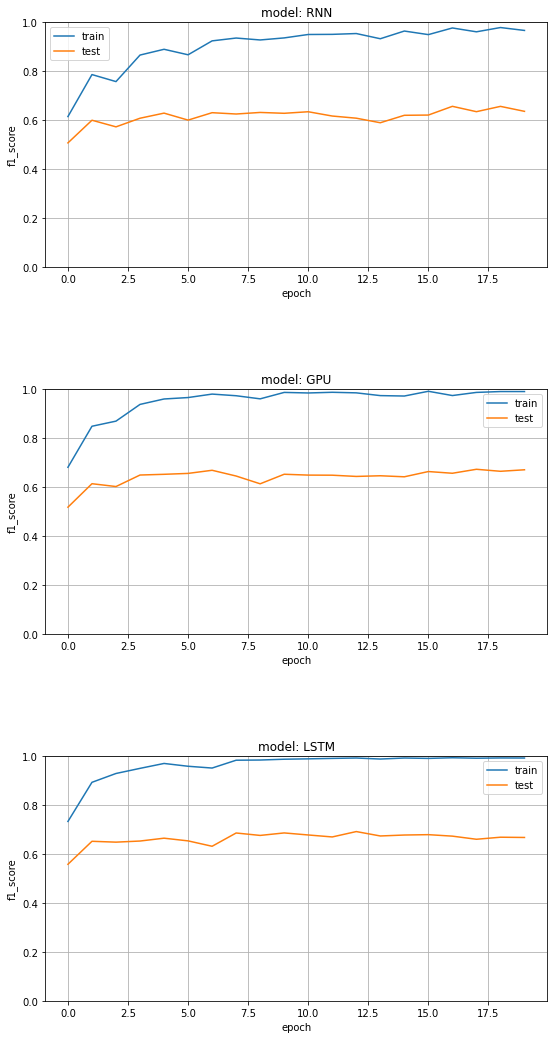

In [89]:
plt.figure(figsize=(9, 18))
i = 1
for key, model_ in models.items():
    plt.subplot(3, 1, i)
    plt.subplots_adjust(hspace=0.5)
    plt.title(f'model: {key}')
    plt.plot(range(len(np.array(hist_train[key])[:,2])), np.array(hist_train[key])[:,2], label = 'train')
    plt.plot(range(len(np.array(hist_test[key])[:,2])), np.array(hist_test[key])[:,2], label = 'test')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('f1_score')
    plt.grid()
    plt.ylim(0,1)
    i +=1

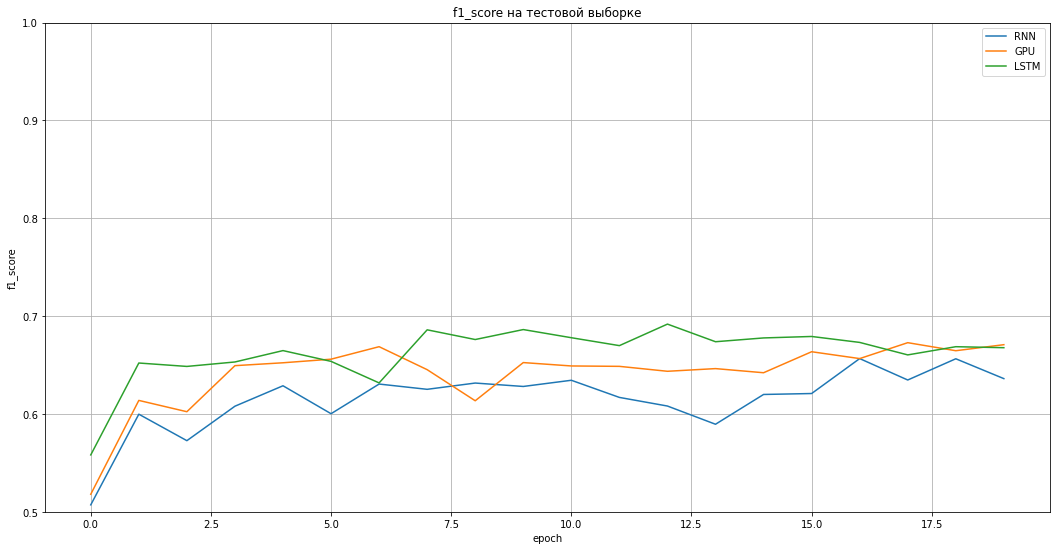

In [90]:
plt.figure(figsize=(18, 9))
for key, model_ in models.items():
    plt.title(f'f1_score на тестовой выборке')
    plt.plot(range(len(np.array(hist_test[key])[:,2])), np.array(hist_test[key])[:,2], label = key)
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('f1_score')
    plt.ylim(0.5,1)
    i +=1

## Выводы:

Тестовые показатели моделей не сильно отличаются. 
Модели обучались на одних и тех же начальных условиях, чтобы сравнение можно было делать более обоснованно. 

LSTM показала самый высокий результат, также можно заметить, что обучение произошло быстрее остальных моделей. На последних итерациях виден процесс переобучения.
